In [30]:
import os 
import json
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import contractions
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

try:
    ENGLISH_STOP_WORDS = set(stopwords.words('english'))
except LookupError:
    print("NLTK stopwords not found. Downloading...")
    nltk.download('stopwords')
    ENGLISH_STOP_WORDS = set(stopwords.words('english'))

try:
    LEMMATIZER = WordNetLemmatizer()
except LookupError:
    print("NLTK 'wordnet' or 'omw-1.4' not found. Downloading...")
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    LEMMATIZER = WordNetLemmatizer()

In [ ]:
parent_dir = os.path.dirname(os.getcwd())
data_path = os.path.join(parent_dir, 'data','cleaned','cleaned_dataset_tripadvisor-reviews_2025-11-01_14-21-09-431.json')

df = pd.read_json(data_path, orient='records')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19493 entries, 0 to 19492
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             19493 non-null  int64 
 1   lang           19493 non-null  object
 2   rating         19493 non-null  int64 
 3   travelDate     19466 non-null  object
 4   publishedDate  19493 non-null  object
 5   tripType       17379 non-null  object
 6   userLocation   11260 non-null  object
 7   review_text    19493 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.2+ MB


,id,lang,rating,travelDate,publishedDate,tripType,userLocation,review_text
0,1016346537,el,1,2025-07-01,2025-07-03,BUSINESS,None,Απαράδεκτο grecotel.. Απαράδεκτο! Έφτασα μετά ...
1,1015574543,en,5,2025-06-01,2025-06-28,FAMILY,None,Family vacation. I was afraid of what the acco...
2,987362026,el,3,2024-12-01,2025-01-02,COUPLES,None,Αδιαφορο. Το ξενοδοχείο χρήζει ανακαίνισης. Τα...
3,979445372,tr,1,2024-11-01,2024-11-10,FAMILY,None,Kahvaltı kuyruğu ve personelin kabalığı. Çocuk...
4,960799391,en,5,2023-08-01,2024-07-23,COUPLES,None,Place to stay in Alexandropoli. Wonderful stay...


In [3]:
# Convert data types
df['travelDate'] = pd.to_datetime(df['travelDate'], errors='coerce')
df['publishedDate'] = pd.to_datetime(df['publishedDate'], errors='coerce')

In [4]:
df.describe()

,id,rating,travelDate,publishedDate
count,1.949300e+04,19493.000000,19466,19493
mean,6.958222e+08,4.423896,2020-05-20 17:10:50.611322112,2020-06-23 22:18:43.233981440
min,1.679000e+03,1.000000,2001-06-01 00:00:00,2003-07-27 00:00:00
25%,4.876367e+08,4.000000,2017-05-01 00:00:00,2017-05-25 00:00:00
50%,7.694020e+08,5.000000,2020-09-01 00:00:00,2020-09-08 00:00:00
75%,9.550619e+08,5.000000,2024-06-01 00:00:00,2024-06-14 00:00:00
max,1.037285e+09,5.000000,2025-11-01 00:00:00,2025-11-01 00:00:00
std,2.878089e+08,0.956051,NaN,NaN


In [5]:
df.describe(include='object')

,lang,tripType,userLocation,review_text
count,19493,17379,11260,19493
unique,25,5,160,19491
top,en,FAMILY,United Kingdom,Absolutely Spectacular. We left the Corfu Impe...
freq,11989,8060,3680,2


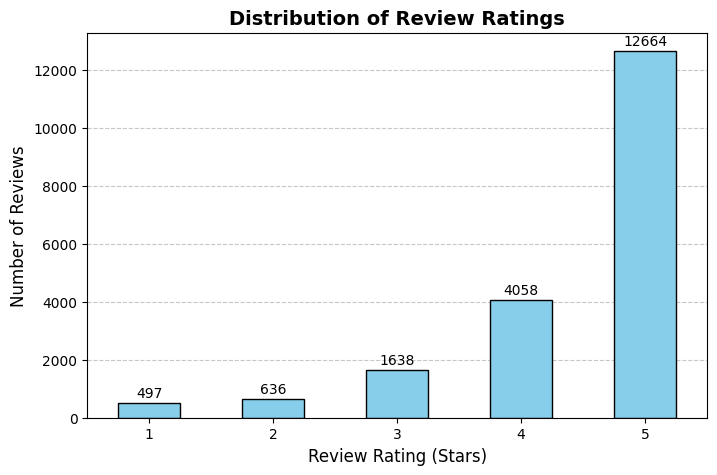

In [6]:
rating_counts = df['rating'].value_counts().sort_index()

plt.figure(figsize=(8, 5))

rating_counts.plot(kind='bar', color='skyblue', edgecolor='black', zorder=2)

plt.title('Distribution of Review Ratings', fontsize=14, weight='bold')
plt.xlabel('Review Rating (Stars)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=0, ha='center') 
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

for i, count in enumerate(rating_counts):
    plt.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=10)

C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_14664\3716885266.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M') \


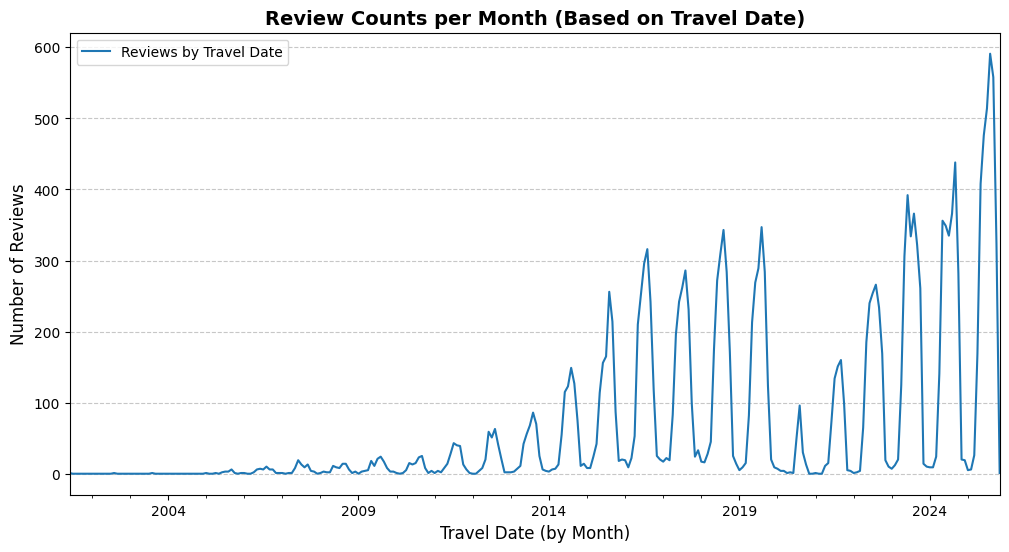

In [7]:
travel_counts = df.dropna(subset=['travelDate']) \
                  .set_index('travelDate') \
                  .resample('M') \
                  .size()

travel_counts.name = "Reviews by Travel Date"

plt.figure(figsize=(12, 6))
travel_counts.plot(kind='line', zorder=2)

plt.title('Review Counts per Month (Based on Travel Date)', fontsize=14, weight='bold')
plt.xlabel('Travel Date (by Month)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)
plt.legend()
plt.show()

C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_14664\3290878473.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M') \


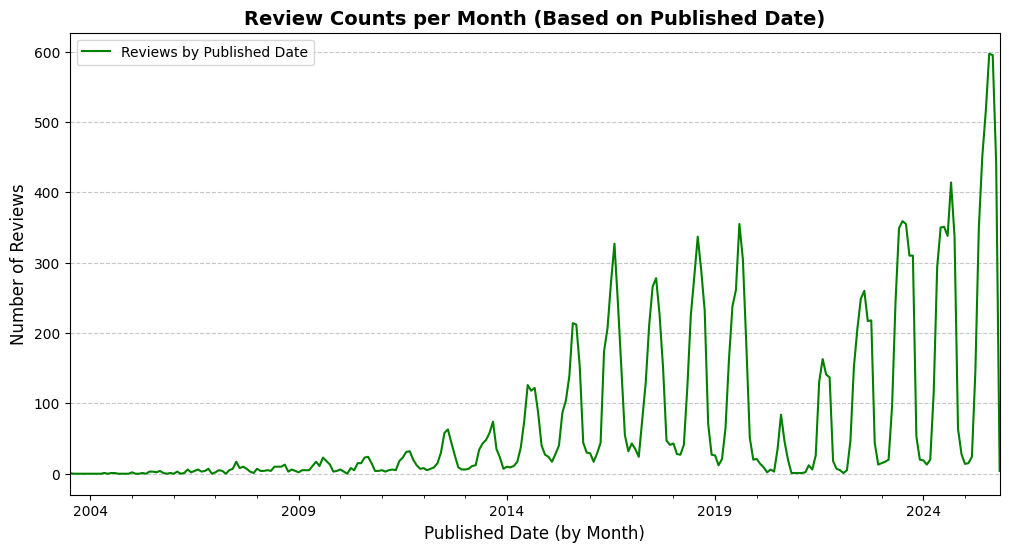

In [8]:
# Repeat the process for the published date
published_counts = df.dropna(subset=['publishedDate']) \
                     .set_index('publishedDate') \
                     .resample('M') \
                     .size()

published_counts.name = "Reviews by Published Date"

plt.figure(figsize=(12, 6))
published_counts.plot(kind='line', color='green', zorder=2)

plt.title('Review Counts per Month (Based on Published Date)', fontsize=14, weight='bold')
plt.xlabel('Published Date (by Month)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)
plt.legend()

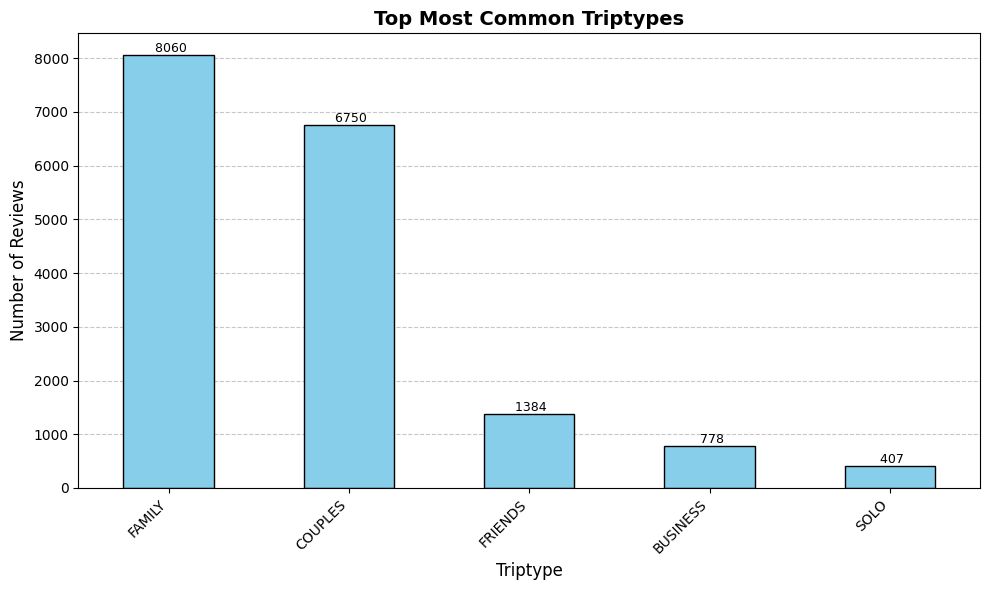

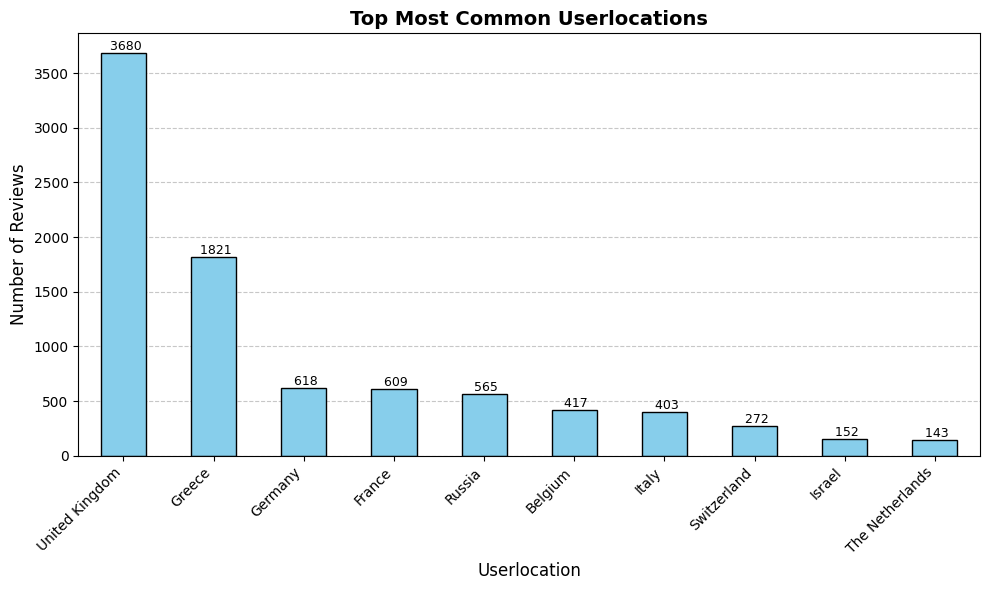

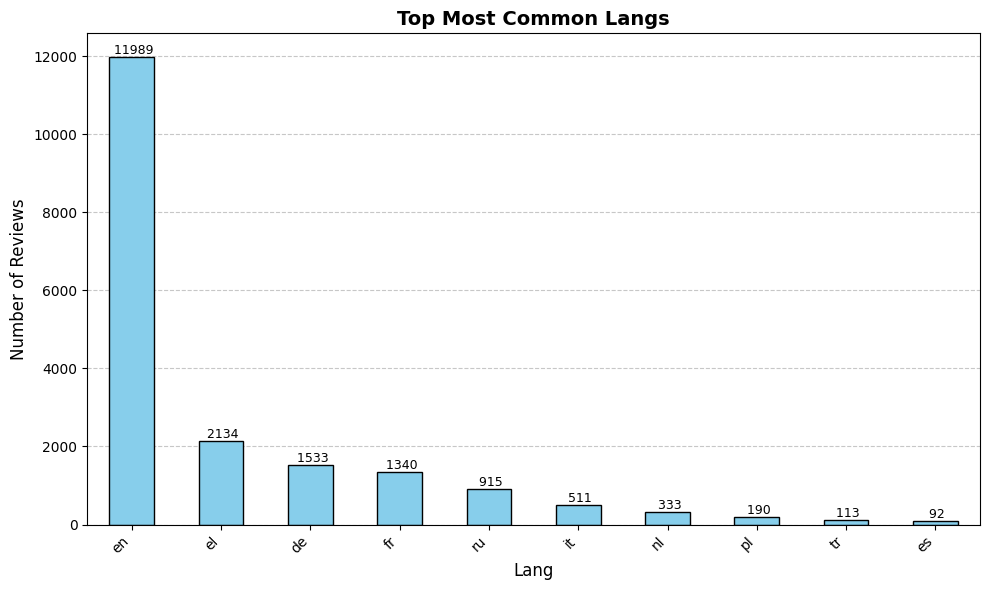

In [9]:
# Columns to plot
columns_to_plot = ['tripType', 'userLocation', 'lang']

for column in columns_to_plot:
    top_10_counts = df[column].value_counts().head(10)

    plt.figure(figsize=(10, 6))
    top_10_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black', zorder=2)

    plt.title(f'Top Most Common {column.replace("_", " ").title()}s', fontsize=14, weight='bold')
    plt.xlabel(column.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
        
    # Rotate labels for readability
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

    # Add data labels on top of the bars
    for i, count in enumerate(top_10_counts.sort_values(ascending=False)):
        plt.text(i, count, f' {count}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_14664\2436032594.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M') \


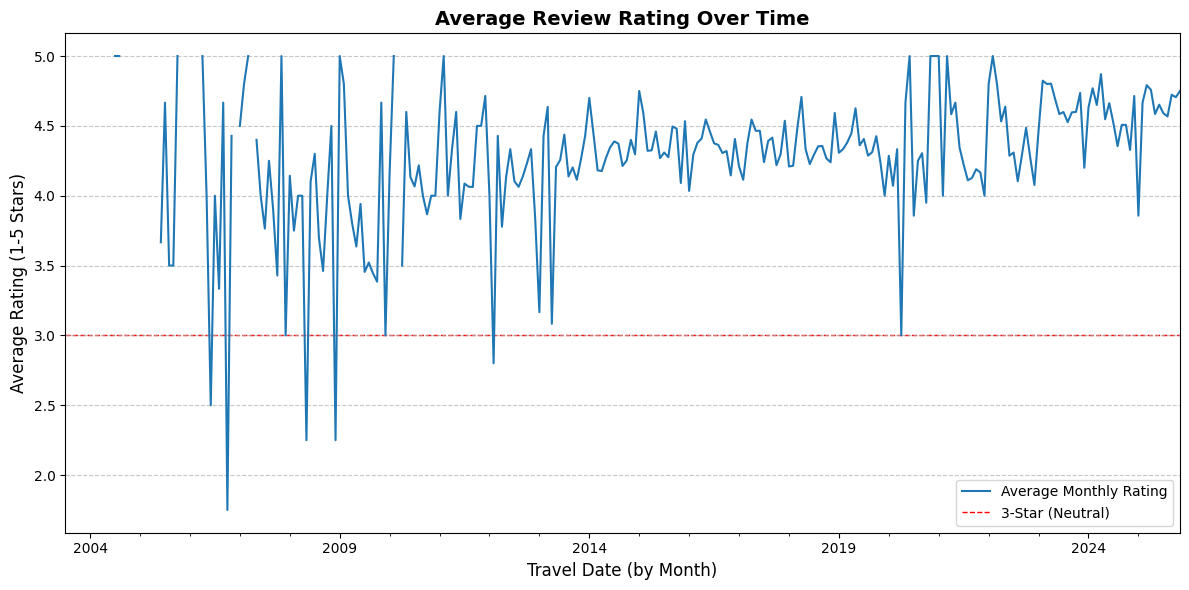

In [10]:
df_cleaned = df.dropna(subset=['publishedDate', 'rating'])

mean_rating_over_time = df_cleaned.set_index('publishedDate') \
                                  ['rating'] \
                                  .resample('M') \
                                  .mean()

mean_rating_over_time.name = "Average Monthly Rating"

plt.figure(figsize=(12, 6))
mean_rating_over_time.plot(kind='line', zorder=2)

plt.title('Average Review Rating Over Time', fontsize=14, weight='bold')
plt.xlabel('Travel Date (by Month)', fontsize=12)
plt.ylabel('Average Rating (1-5 Stars)', fontsize=12)

plt.axhline(y=3, color='red', linestyle='--', linewidth=1, zorder=1, label='3-Star (Neutral)')

plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_14664\2977004051.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M') \


Old period peak (2014-2019): 347 reviews in a month.
Start of 'new normal' (first month > old peak): 2023-06


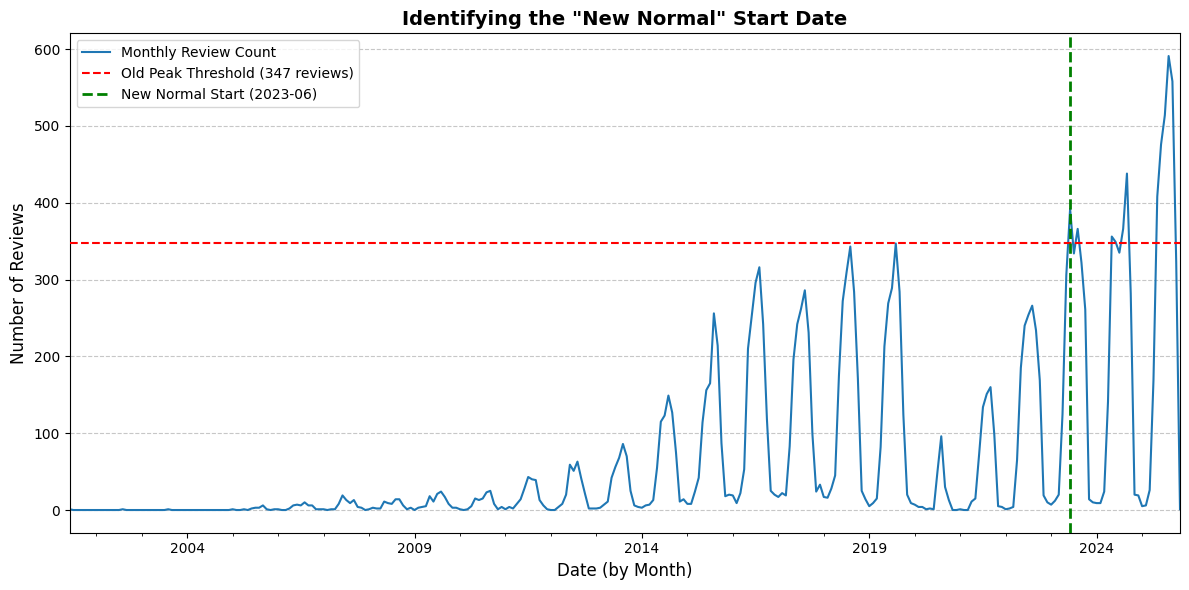

In [11]:
# Get the monthly counts
travel_counts = df.dropna(subset=['travelDate']) \
                  .set_index('travelDate') \
                  .resample('M') \
                  .size()
travel_counts.name = "Monthly Reviews"

# Define the "old" period (before the gap)
old_data_counts = travel_counts.loc['2014':'2019']
old_peak_volume = old_data_counts.max()

print(f"Old period peak (2014-2019): {old_peak_volume:.0f} reviews in a month.")

# Find the "New Normal" Start Date 
# Define the "new" period (after the gap)
new_data_counts = travel_counts.loc['2023':]

# Find the first month where the count is *greater than* the old peak
start_of_new_normal_series = new_data_counts[new_data_counts > old_peak_volume]

new_start_date = None
if start_of_new_normal_series.empty:
    print("Could not find a 'new normal' start date based on this logic.")
else:
    # Get the timestamp of the first item
    new_start_date = start_of_new_normal_series.index[0]
    print(f"Start of 'new normal' (first month > old peak): {new_start_date.strftime('%Y-%m')}")

# Plot and Annotate 
plt.figure(figsize=(12, 6))
travel_counts.plot(kind='line', zorder=2, label='Monthly Review Count')

plt.title('Identifying the "New Normal" Start Date', fontsize=14, weight='bold')
plt.xlabel('Date (by Month)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Plot the 'old peak' threshold line
plt.axhline(y=old_peak_volume, color='red', linestyle='--', linewidth=1.5, zorder=3, 
            label=f'Old Peak Threshold ({old_peak_volume:.0f} reviews)')

# Plot the 'new normal' start line
if new_start_date:
    plt.axvline(x=new_start_date, color='green', linestyle='--', linewidth=2, zorder=3, 
                label=f"New Normal Start ({new_start_date.strftime('%Y-%m')})")

plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
df_filtered = df[df['travelDate'] >= '2023-06-01'].copy()
df_filtered = df_filtered[['id','lang', 'rating','review_text']]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7124 entries, 0 to 19408
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7124 non-null   int64 
 1   lang         7124 non-null   object
 2   rating       7124 non-null   int64 
 3   review_text  7124 non-null   object
dtypes: int64(2), object(2)
memory usage: 278.3+ KB


##### Text Analysis

In [13]:

def expand_contractions(text:str):
    expanded_words = []
    for word in text.split():
        expanded_words.append(contractions.fix(word)) 

    expanded_text = ' '.join(expanded_words)
    return expanded_text

def normalize_repeated_chars(text:str):
    repeated_char_pattern = r'([a-zA-Z])\1{3,}'

    # replace the match with the first character from the capturing group
    return re.sub(repeated_char_pattern, r'\1', text)

def remove_noisy_chars(text:str):
    noise_pattern = re.compile(r':\w+:|[^a-z\s]')
    
    # Replace all matched noise with a space (to avoid merging words)
    text = re.sub(noise_pattern, ' ', text)
    
    # Clean up extra whitespace created by the replacements
    return re.sub(r'\s+', ' ', text).strip()

def remove_stopwords(text:str) -> str:
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    return " ".join(filtered_tokens)

def lemmatize_text(text:str) -> str:
    tokens = text.split()
    lemmatized_tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    return " ".join(lemmatized_tokens)

In [14]:
# Use only english reviews for now
df_filtered= df_filtered[df_filtered['lang'] == 'en']
df_filtered.shape

(4915, 4)

In [15]:
df_filtered['review_text'] = df_filtered['review_text'].str.lower()
df_filtered['review_text'] = df_filtered['review_text'].apply(expand_contractions)
df_filtered['review_text'] = df_filtered['review_text'].apply(normalize_repeated_chars)
df_filtered['review_text'] = df_filtered['review_text'].apply(remove_noisy_chars)
df_filtered['review_text'] = df_filtered['review_text'].apply(remove_stopwords)
df_filtered['review_text'] = df_filtered['review_text'].apply(lemmatize_text)

In [16]:
# Create review character length and word count in separate columns
df_filtered['review_char_length'] = df_filtered['review_text'].str.len()
df_filtered['review_word_count'] = df_filtered['review_text'].str.split().str.len()

In [17]:
df_filtered[['review_char_length', 'review_word_count']].describe()

,review_char_length,review_word_count
count,4915.000000,4915.000000
mean,703.524924,103.887691
std,720.687308,108.640268
min,68.000000,11.000000
25%,252.000000,36.000000
50%,455.000000,66.000000
75%,899.000000,133.000000
max,7533.000000,1180.000000


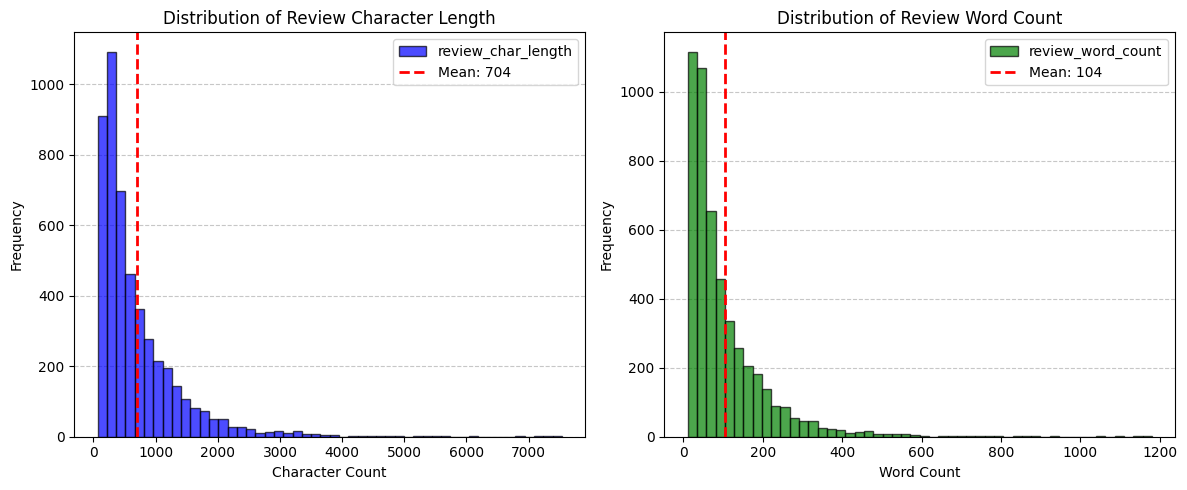

In [18]:
plt.figure(figsize=(12, 5)) 

# Plot 1: Character Length
plt.subplot(1, 2, 1) 
df_filtered['review_char_length'].plot(kind='hist', bins=50, color='blue', edgecolor='black', alpha=0.7, zorder=2)
plt.title('Distribution of Review Character Length', fontsize=12)
plt.xlabel('Character Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

# Add a vertical line for the mean
mean_char = df_filtered['review_char_length'].mean()
plt.axvline(mean_char, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_char:.0f}')
plt.legend()

# Plot 2: Word Count
plt.subplot(1, 2, 2) 
df_filtered['review_word_count'].plot(kind='hist', bins=50, color='green', edgecolor='black', alpha=0.7, zorder=2)
plt.title('Distribution of Review Word Count', fontsize=12)
plt.xlabel('Word Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

# Add a vertical line for the mean
mean_word = df_filtered['review_word_count'].mean()
plt.axvline(mean_word, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_word:.0f}')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_14664\3389034739.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


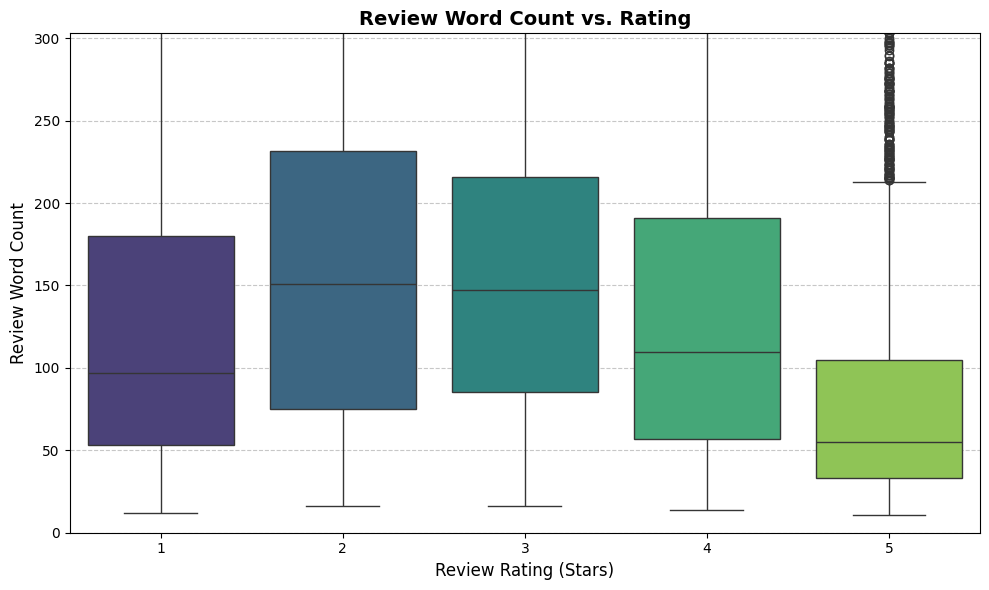

In [19]:
# Use the 95th percentile to cut off extreme outliers for visibility
y_limit = df_filtered['review_word_count'].quantile(0.95)

# Create the Box Plot ---
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df_filtered,
    x='rating',
    y='review_word_count',
    palette='viridis'
)

plt.title('Review Word Count vs. Rating', fontsize=14, weight='bold')
plt.xlabel('Review Rating (Stars)', fontsize=12)
plt.ylabel('Review Word Count', fontsize=12)
plt.ylim(0, y_limit) 
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)
plt.tight_layout()
plt.show()

##### N-Gram Analysis

In [55]:

def get_top_ngrams_and_plot(corpus, ngram_range, title, top_n):
    """
    Vectorizes a text corpus, finds the top 25 n-grams, and plots them.
    """
    print(f"\n--- Generating: {title} ---")
    
    # Vectorize
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    X = vec.transform(corpus)
    
    # Get counts
    counts = X.sum(axis=0)
    words = vec.get_feature_names_out()
    
    # Create DataFrame and get top 25
    df_ngrams = pd.DataFrame(counts.T, index=words, columns=['count'])
    top_ngrams = df_ngrams.sort_values('count', ascending=False).head(top_n)
     
    # Plot
    fig, ax = plt.subplots(figsize=(10, top_n * 0.2))

    top_ngrams.sort_values('count', ascending=True).plot(
        kind='barh', 
        color='skyblue', 
        edgecolor='black', 
        zorder=2,
        ax = ax,
        legend=False
    )
    
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('N-gram', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7, zorder=1)
    plt.tight_layout()
    plt.show()


--- Generating: Top Unigrams ---


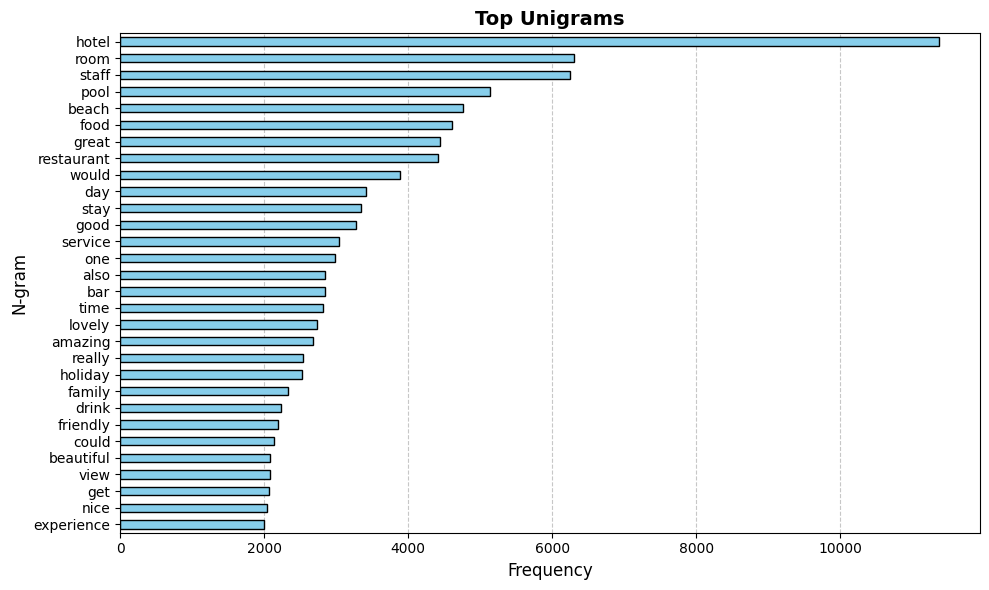


--- Generating: Top Bigrams ---


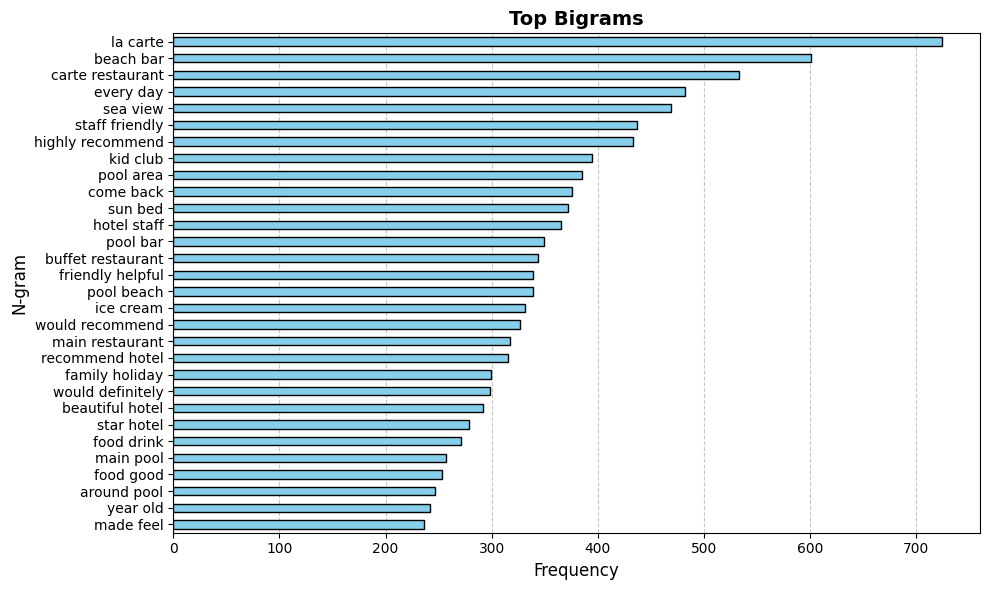


--- Generating: Top Trigrams ---


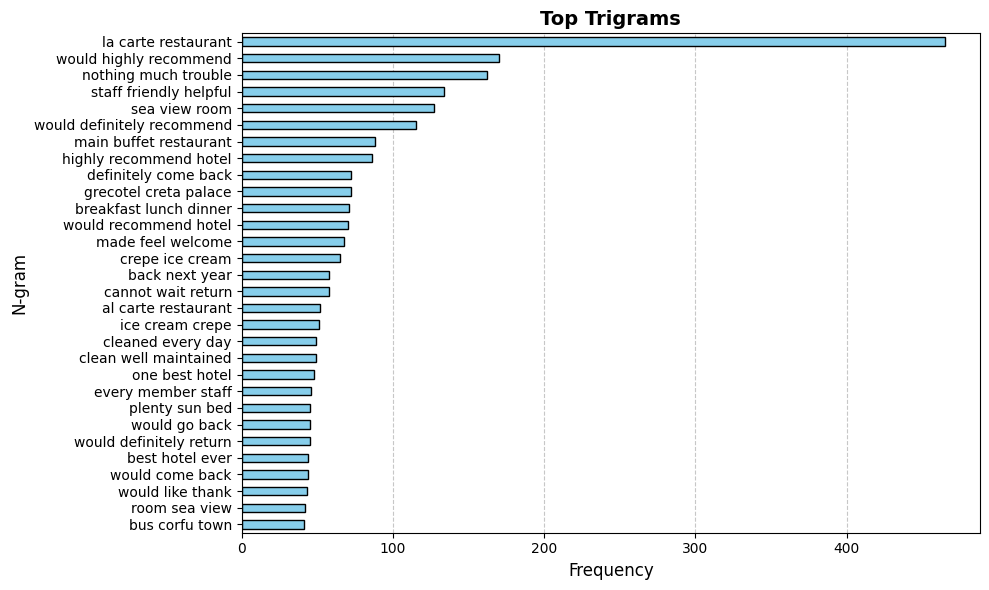

In [63]:
corpus = df_filtered['review_text']
# Run for Unigrams
get_top_ngrams_and_plot(corpus, (1, 1), 'Top Unigrams', 30)

# Run for Bigrams
get_top_ngrams_and_plot(corpus, (2, 2), 'Top Bigrams', 30)

# Run for Trigrams
get_top_ngrams_and_plot(corpus, (3, 3), 'Top Trigrams', 30)

##### Contextual N-grams 

In [22]:
def get_top_ngrams_data(corpus, ngram_range, n=20):
    """
    Vectorizes a text corpus and returns a DataFrame of the top n-grams.
    """
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    X = vec.transform(corpus)
    counts = X.sum(axis=0)
    words = vec.get_feature_names_out()
    
    df_ngrams = pd.DataFrame(counts.T, index=words, columns=['count'])
    return df_ngrams.sort_values('count', ascending=False).head(n)


Positive (4-5 star) reviews in corpus: 4352
Negative (1-2 star) reviews in corpus: 245


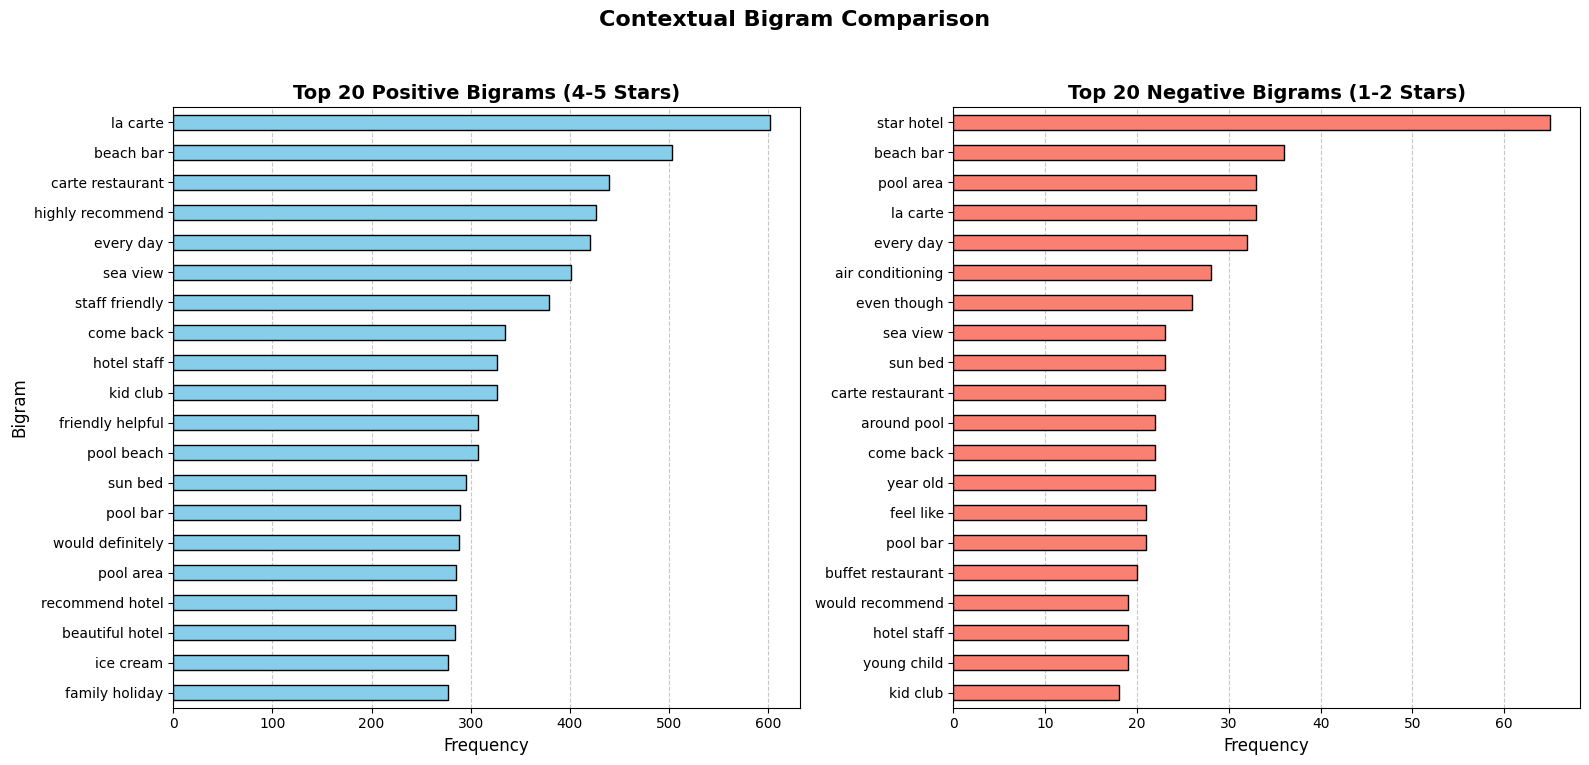

In [23]:
# Split into Positive and Negative Corpora 
# We exclude 3-star reviews as they are neutral
df_positive = df_filtered[df_filtered['rating'] >= 4]
df_negative = df_filtered[df_filtered['rating'] <= 2]

corpus_positive = df_positive['review_text']
corpus_negative = df_negative['review_text']

print(f"\nPositive (4-5 star) reviews in corpus: {len(corpus_positive)}")
print(f"Negative (1-2 star) reviews in corpus: {len(corpus_negative)}")

# Get the top 20 bigrams for each
top_positive_bigrams = get_top_ngrams_data(corpus_positive, (2, 2), 20)
top_negative_bigrams = get_top_ngrams_data(corpus_negative, (2, 2), 20)

fig, axes = plt.subplots(1, 2, figsize=(16, 8)) # 1 row, 2 columns

# Plot 1: Positive Bigrams
top_positive_bigrams.sort_values('count', ascending=True).plot(
    kind='barh', 
    ax=axes[0], 
    color='skyblue', 
    edgecolor='black', 
    zorder=2,
    legend=False
)
axes[0].set_title('Top 20 Positive Bigrams (4-5 Stars)', fontsize=14, weight='bold')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Bigram', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7, zorder=1)

# Plot 2: Negative Bigrams
top_negative_bigrams.sort_values('count', ascending=True).plot(
    kind='barh', 
    ax=axes[1], 
    color='salmon', 
    edgecolor='black', 
    zorder=2,
    legend=False
)
axes[1].set_title('Top 20 Negative Bigrams (1-2 Stars)', fontsize=14, weight='bold')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel(None) # Hide y-label
axes[1].grid(axis='x', linestyle='--', alpha=0.7, zorder=1)

plt.suptitle('Contextual Bigram Comparison', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()

In [67]:
def generate_aspect_wordcloud(df, aspect_name, keywords):

    print(f"\n--- Generating Word Cloud for: {aspect_name} ---")

    keyword_pattern = r'\b(' + '|'.join(re.escape(k) for k in keywords) + r')\b'

    corpus_df = df[df['review_text'].str.contains(keyword_pattern, na=False)]

    if corpus_df.empty:
        print(f"No text found for aspect: {aspect_name}")
        return
    
    full_text = " ".join(corpus_df['review_text'])

    # Tokenize the entire text
    words = full_text.lower().split()
    
    # Get counts of *all* words
    all_word_counts = Counter(words)

    # Create a new dictionary containing *only* the counts for your keywords
    keyword_frequencies = {}
    for keyword in keywords:
        if keyword in all_word_counts:
            keyword_frequencies[keyword] = all_word_counts[keyword]
    
    if not keyword_frequencies:
        print("Found matching reviews, but keywords were not found. Aborting.")
    else:
        print(f"Keyword frequencies:\n {keyword_frequencies}")
    
    # --- 5. Create the Word Cloud *from frequencies* ---
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            colormap='viridis'
        ).generate_from_frequencies(keyword_frequencies)
    
    # 5. Plot the Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Aspect: {aspect_name}', fontsize=14, weight='bold')
    plt.axis('off') # Hide the x/y axes
    plt.show()


--- Generating Word Cloud for: ROOM ---


C:\Users\Βασίλης\AppData\Local\Temp\ipykernel_14664\4267240296.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  corpus_df = df[df['review_text'].str.contains(keyword_pattern, na=False)]


Keyword frequencies:
 {'room': 6302, 'suite': 218, 'ac': 48, 'balcony': 402, 'bed': 1646, 'pillow': 132, 'mattress': 80, 'shower': 483, 'kitchen': 78, 'bathroom': 537, 'toilet': 216}


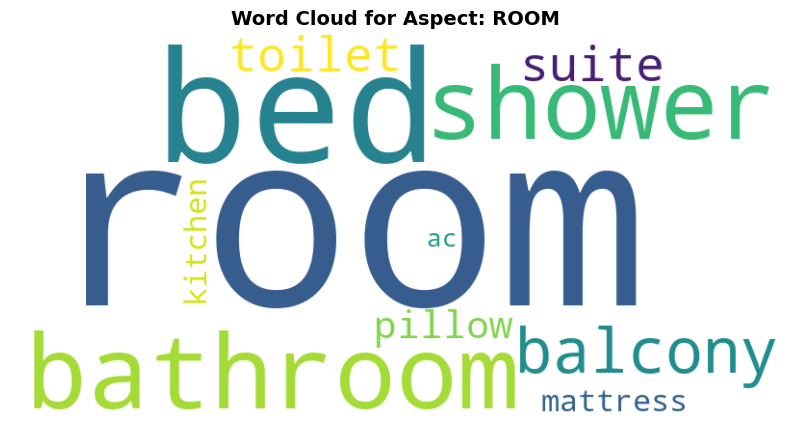


--- Generating Word Cloud for: FOOD ---
Keyword frequencies:
 {'food': 4614, 'restaurant': 4409, 'breakfast': 1453, 'buffet': 1655, 'dinner': 826, 'bar': 2839, 'drink': 2229, 'choice': 920, 'meal': 676, 'menu': 332}


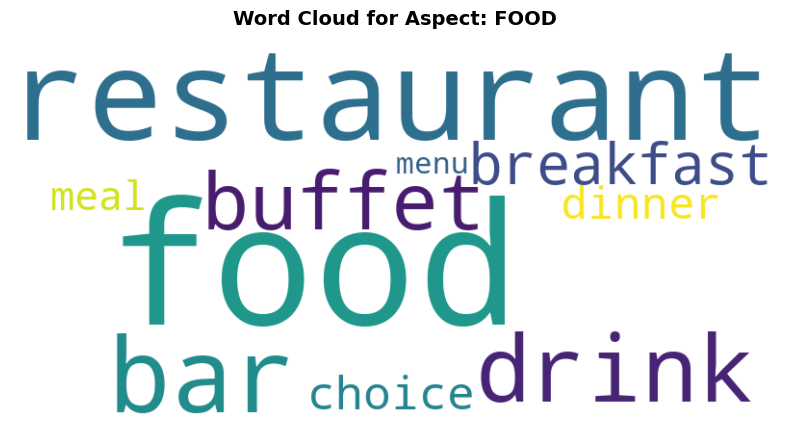


--- Generating Word Cloud for: SERVICE ---
Keyword frequencies:
 {'service': 3033, 'staff': 6254, 'reception': 1033, 'waiter': 225, 'host': 53, 'hostess': 28, 'housekeeping': 200, 'concierge': 139, 'manager': 643, 'friendly': 2194, 'helpful': 1213, 'rude': 89, 'warm': 548, 'welcoming': 437, 'transfer': 186}


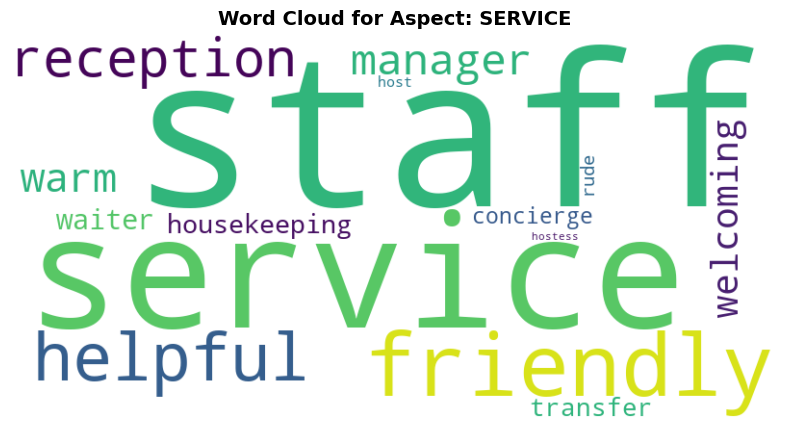


--- Generating Word Cloud for: FACILITIES ---
Keyword frequencies:
 {'pool': 5133, 'sunbed': 163, 'jacuzzi': 27, 'gym': 414, 'spa': 377, 'sauna': 38, 'fitness': 102, 'wifi': 117}


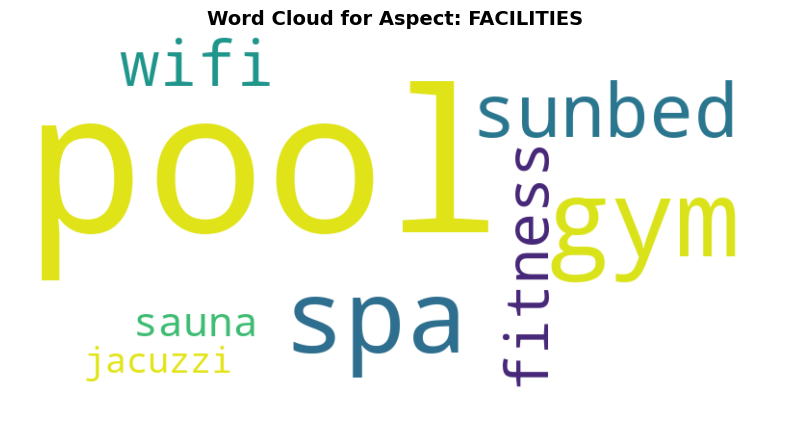


--- Generating Word Cloud for: LOCATION ---
Keyword frequencies:
 {'location': 1125, 'close': 334, 'view': 2079, 'beach': 4757, 'airport': 215, 'town': 785, 'centre': 76}


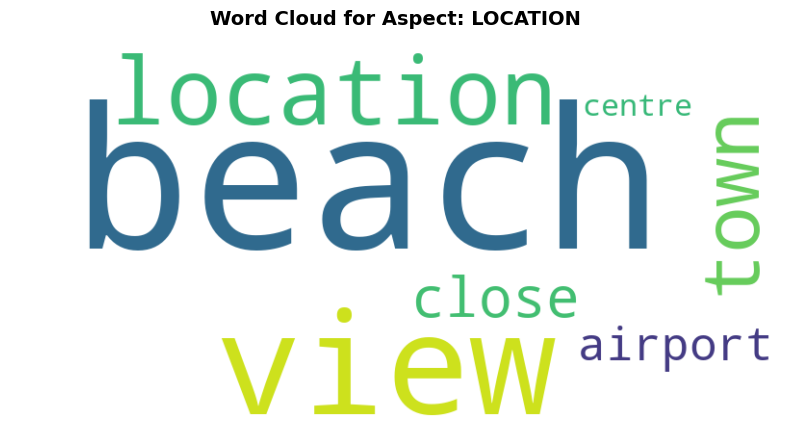


--- Generating Word Cloud for: VALUE_FOR_MONEY ---
Keyword frequencies:
 {'price': 374, 'pay': 214, 'expensive': 194, 'worth': 475, 'cheap': 85, 'luxury': 412, 'cost': 219, 'money': 267, 'value': 223, 'reasonable': 51, 'pricey': 33, 'overpriced': 29}


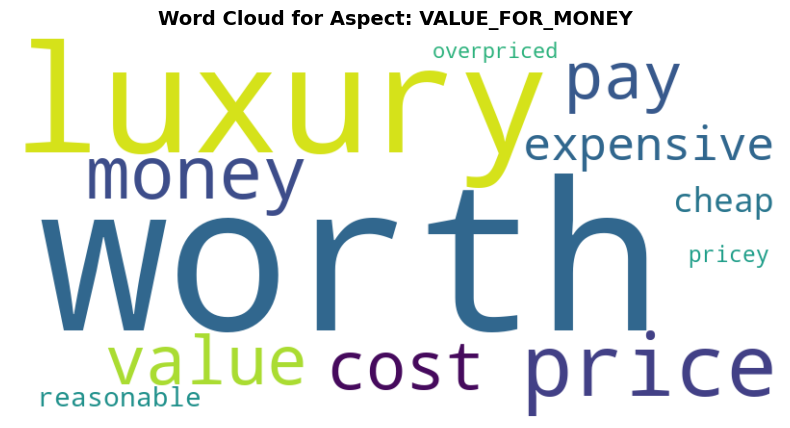


--- Generating Word Cloud for: CLEANLINESS ---
Keyword frequencies:
 {'clean': 1617, 'cleaner': 143, 'dirty': 157, 'tidy': 75, 'maintained': 293}


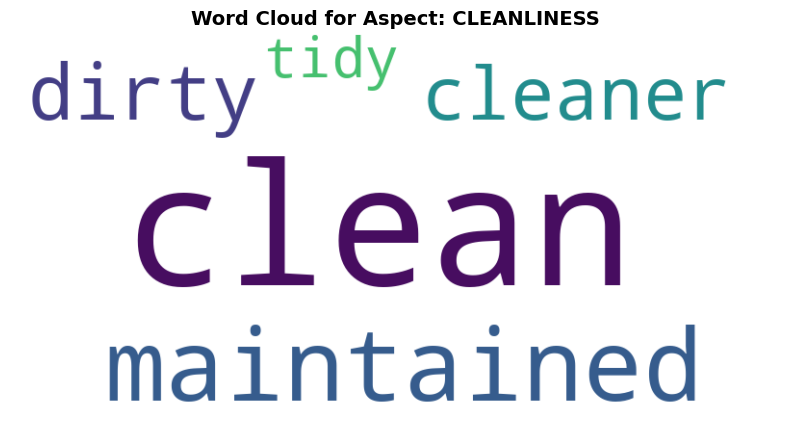


--- Generating Word Cloud for: COMFORT ---
Keyword frequencies:
 {'rest': 197, 'comfortable': 775, 'comfort': 204, 'sleep': 141, 'quiet': 344, 'relax': 245, 'privacy': 50, 'noise': 137}


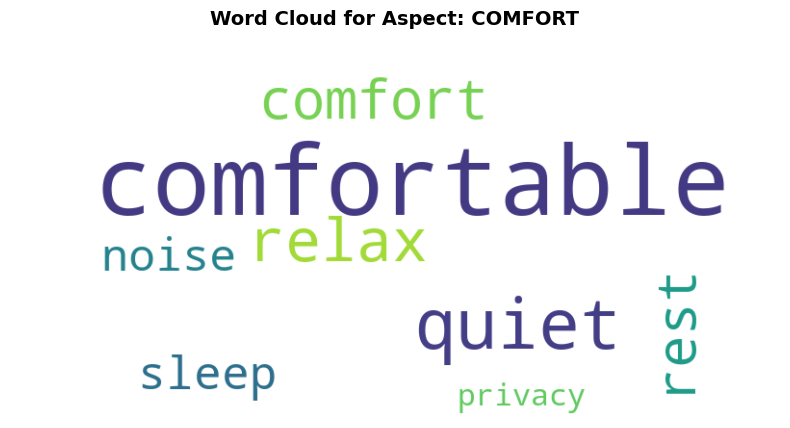

In [68]:
aspects_path = os.path.join(parent_dir, 'absa','aspect_keywords.json')

with open(aspects_path, 'r', encoding="utf-8") as f:
    ASPECT_KEYWORDS = json.load(f)

for aspect, keywords in ASPECT_KEYWORDS.items():
    generate_aspect_wordcloud(df_filtered, aspect, keywords)